# GEOG 392/676, Team 3, Final Code
# Spatial Analysis of Texas Public Education Data
### Team Members: Ravi Bhardwaj (GL), Caroline Caffey, Allison Clarke (GL), Rachael Jones, and Delia Pastore


# Data Processing

### Packages

In [1]:
#import for pandas, geopandas
import pandas as pd
import geopandas as gpd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn
import sklearn
from sklearn.preprocessing import MinMaxScaler #[0-1]
from sklearn.cluster import KMeans

In [2]:
#retrieve data from google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Import Data

In [4]:
# Campus Statistics
tea_var = pd.read_csv('/content/drive/Shareddrives/GEOG 392 676 Project/TEA Data/TEA_Var.csv')
tea_var.head(2)

School_Name District_Name  \
0  21ST CENTURY EARLY LEARNING FOUNDATIONS ACADEMY   WESLACO ISD   
1                                       3D ACADEMY     DONNA ISD   

  Chronic_Absenteeism_Rate Dropout_0708 Dropout_0912 SAT_Avg ACT_Avg  \
0                        .            .            .       .       .   
1                     66.5            .          5.4       .      -1   

  Teacher_Student_Ratio Meets_GL_STD  
0                  35.8            .  
1                  12.9           17

In [5]:
# Reference Data
cref = pd.read_csv('/content/drive/Shareddrives/GEOG 392 676 Project/TEA Data/CREF.csv')
cref.head(2)

Distr REGION   GRDSPAN      CAMPUS GRDTYPE C_RATING DISTRICT    School_Name  \
0  '001    '07  '09 - 12  '001902001       S        A  '001902     CAYUGA H S   
1  '001    '07  '06 - 08  '001902041       M        B  '001902  CAYUGA MIDDLE   

  District_Name  CNTYNAME CFLCHART CFLALTED  
0    CAYUGA ISD  ANDERSON        N        N  
1    CAYUGA ISD  ANDERSON        N        N

In [6]:
# Texas Schools Shapefile
tx_schools = gpd.read_file('/content/drive/Shareddrives/GEOG 392 676 Project/TEA Data/Schools_2022_to_2023')
tx_schools.head(2)

ObjectID Status  Score Match_type  \
0         1      M  100.0          A   
1         2      M  100.0          A   

                                          Match_addr  \
0  17750 N US Highway 287, Tennessee Colony, Texa...   
1  17750 N US Highway 287, Tennessee Colony, Texa...   

                                           LongLabel              ShortLabel  \
0  17750 N US Highway 287, Tennessee Colony, TX, ...  17750 N US Highway 287   
1  17750 N US Highway 287, Tennessee Colony, TX, ...  17750 N US Highway 287   

       Addr_type  Type PlaceName  ...      USER_Sch11            USER_Sch12  \
0  StreetAddress  None      None  ...  (903) 928-2646  admin1@cayugaisd.com   
1  StreetAddress  None      None  ...  (903) 928-2239  admin1@cayugaisd.com   

          USER_Sch13           USER_Sch14 USER_Grade USER_Sch15 USER_Sch16  \
0  www.cayugaisd.com  MRS JENNI SCHEPPLER      06-08        166     Active   
1  www.cayugaisd.com         JAY THOMPSON      09-12        171     Active   

   USER_Sch17            USER_Updat                    geometry  
0  1996-03-11  4/20/2023 5:41:12 AM  POINT (-95.92474 31.92226)  
1        None  4/20/2023 5:41:12 AM  POINT (-95.92474 31.92226)  

[2 rows x 118 columns]

In [7]:
# Current School Districts Shapefile
school_districts = gpd.read_file('/content/drive/Shareddrives/GEOG 392 676 Project/TEA Data/Current_Districts_2023')
school_districts = school_districts[['NAME','geometry']]
school_districts.head(2)

NAME                                           geometry
0    Nederland ISD  POLYGON ((-94.04917 29.96124, -94.04914 29.965...
1  Sabine Pass ISD  POLYGON ((-94.35550 29.72861, -94.34821 29.728...

In [8]:
# Texas Counties Shapefile
counties = gpd.read_file('/content/drive/Shareddrives/GEOG 392 676 Project/TEA Data/Counties')
counties['County'] = counties['FENAME']
counties = counties[['County','geometry']]
counties.head(2)

County                                           geometry
0  DALLAM  POLYGON ((-102.16246 36.50033, -102.16242 36.5...
1  BORDEN  POLYGON ((-101.55743 32.96103, -101.55406 32.9...

<Axes: >

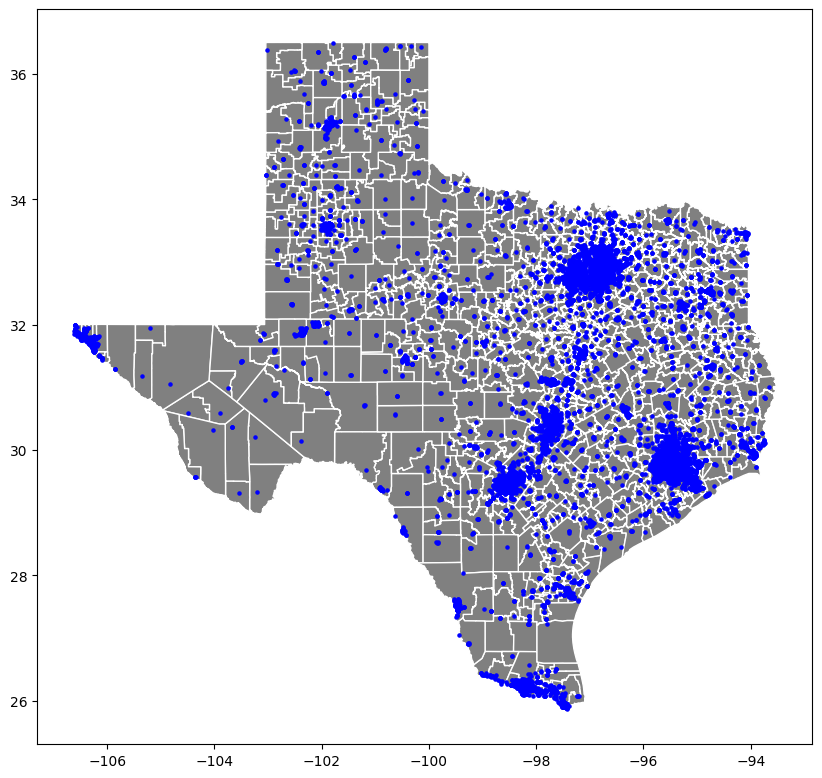

In [9]:
# Plot Schools and School Districts, Verify Imports
ax = school_districts.plot(color = 'grey', edgecolor = 'white', figsize = (10,10))
tx_schools.plot(ax = ax, color = 'blue', markersize = 5)

## Data Cleaning

In [10]:
# clean and restructure the 'tx_schools' dataframe
tx_schools['School_Name'] = tx_schools['USER_Sch_1']
tx_schools['District_Name'] = tx_schools['USER_Dis_1']

# remove unnecessary data values
tx_schools = tx_schools[['School_Name', 'District_Name','geometry',]] # clean data
tx_schools['School_and_District'] = tx_schools['School_Name'] + "_" + tx_schools['District_Name']
tx_schools = tx_schools.drop(columns = ['School_Name','District_Name'])
tx_schools.head(2)

geometry       School_and_District
0  POINT (-95.92474 31.92226)  CAYUGA MIDDLE_CAYUGA ISD
1  POINT (-95.92474 31.92226)     CAYUGA H S_CAYUGA ISD

In [11]:
# Combine school and district names, and simplify the DataFrame.
tea_var['School_and_District'] = tea_var['School_Name'] + "_" + tea_var['District_Name']
tea_var = tea_var.drop(columns = ['School_Name','District_Name'])
tea_var.head(2)

Chronic_Absenteeism_Rate Dropout_0708 Dropout_0912 SAT_Avg ACT_Avg  \
0                        .            .            .       .       .   
1                     66.5            .          5.4       .      -1   

  Teacher_Student_Ratio Meets_GL_STD  \
0                  35.8            .   
1                  12.9           17   

                                 School_and_District  
0  21ST CENTURY EARLY LEARNING FOUNDATIONS ACADEM...  
1                               3D ACADEMY_DONNA ISD

In [12]:
# Simplify DataFrame by combining and selecting columns.
cref = cref[['School_Name', 'District_Name','GRDSPAN', 'GRDTYPE']] # clean data
cref['School_and_District'] = cref['School_Name'] + "_" + cref['District_Name']
cref = cref.drop(columns = ['School_Name','District_Name'])
cref.head(2)

GRDSPAN GRDTYPE       School_and_District
0  '09 - 12       S     CAYUGA H S_CAYUGA ISD
1  '06 - 08       M  CAYUGA MIDDLE_CAYUGA ISD

## Merge CSV and SHP Data

In [13]:
# merge school shapefile data with tea variable data to create master dataframe
merge_school = tx_schools.merge(tea_var, how = 'inner', on = 'School_and_District')
merged_values = merge_school.merge(cref, how = 'inner', on = 'School_and_District')
merged_values.head(2)

geometry       School_and_District  \
0  POINT (-95.92474 31.92226)  CAYUGA MIDDLE_CAYUGA ISD   
1  POINT (-95.92474 31.92226)     CAYUGA H S_CAYUGA ISD   

  Chronic_Absenteeism_Rate Dropout_0708 Dropout_0912 SAT_Avg ACT_Avg  \
0                      3.8            0            .       .       .   
1                       13            .            0     980       .   

  Teacher_Student_Ratio Meets_GL_STD   GRDSPAN GRDTYPE  
0                  13.3           52  '06 - 08       M  
1                  10.1           72  '09 - 12       S

## Data for Analysis

In [14]:
# middle school data
middle_school = merged_values[merged_values['GRDTYPE'] == 'M']
middle_school = middle_school[['School_and_District','Chronic_Absenteeism_Rate','Dropout_0708','Teacher_Student_Ratio','Meets_GL_STD','GRDSPAN', 'GRDTYPE','geometry']]

In [15]:
# locate schools that are missing data
middle_school['Chronic_Absenteeism_Rate'] = pd.to_numeric(middle_school['Chronic_Absenteeism_Rate'], errors = 'coerce')
middle_school['Dropout_0708'] = pd.to_numeric(middle_school['Dropout_0708'], errors = 'coerce')
middle_school['Teacher_Student_Ratio'] = pd.to_numeric(middle_school['Teacher_Student_Ratio'], errors = 'coerce')
middle_school['Meets_GL_STD'] = pd.to_numeric(middle_school['Meets_GL_STD'], errors = 'coerce')

# drop all NaN values
middle_school = middle_school.dropna(subset = ['Chronic_Absenteeism_Rate'])
middle_school = middle_school.dropna(subset = ['Dropout_0708'])
middle_school = middle_school.dropna(subset = ['Teacher_Student_Ratio'])
middle_school = middle_school.dropna(subset = ['Meets_GL_STD'])

# drop rows with negative values
middle_school = middle_school[middle_school['Chronic_Absenteeism_Rate']>=0]
middle_school = middle_school[middle_school['Dropout_0708']>=0]
middle_school = middle_school[middle_school['Teacher_Student_Ratio']>=0]
middle_school = middle_school[middle_school['Meets_GL_STD']>=0]

middle_school.head(2)

School_and_District  Chronic_Absenteeism_Rate  Dropout_0708  \
0    CAYUGA MIDDLE_CAYUGA ISD                       3.8           0.0   
3  ELKHART MIDDLE_ELKHART ISD                       4.3           0.0   

   Teacher_Student_Ratio  Meets_GL_STD   GRDSPAN GRDTYPE  \
0                   13.3          52.0  '06 - 08       M   
3                   11.7          52.0  '06 - 08       M   

                     geometry  
0  POINT (-95.92474 31.92226)  
3  POINT (-95.57932 31.62690)

In [16]:
middle_school.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_RAW_DATA.shp')

Text(0.5, 1.0, 'Middle School Data')

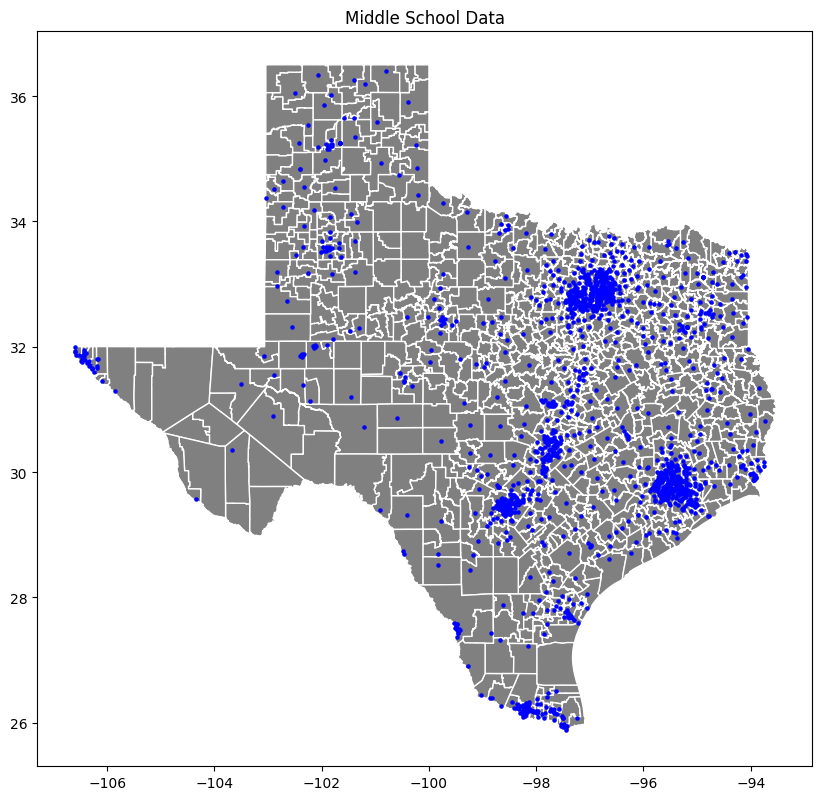

In [17]:
ax = school_districts.plot(color = 'grey', edgecolor = 'white', figsize = (10,10))
middle_school.plot(ax = ax, color = 'blue', markersize = 5)
plt.title('Middle School Data')

In [18]:
# high school data
high_school = merged_values[merged_values['GRDTYPE'] == 'S']
high_school = merged_values[merged_values['GRDSPAN'] == '\'09 - 12']
high_school = high_school[['School_and_District','Chronic_Absenteeism_Rate','Dropout_0912','Teacher_Student_Ratio','Meets_GL_STD','SAT_Avg', 'ACT_Avg', 'GRDSPAN', 'GRDTYPE','geometry']]

In [19]:
# locate schools that are missing data
high_school['Chronic_Absenteeism_Rate'] = pd.to_numeric(high_school['Chronic_Absenteeism_Rate'], errors = 'coerce')
high_school['Dropout_0912'] = pd.to_numeric(high_school['Dropout_0912'], errors = 'coerce')
high_school['Teacher_Student_Ratio'] = pd.to_numeric(high_school['Teacher_Student_Ratio'], errors = 'coerce')
high_school['Meets_GL_STD'] = pd.to_numeric(high_school['Meets_GL_STD'], errors = 'coerce')
high_school['SAT_Avg'] = pd.to_numeric(high_school['SAT_Avg'], errors = 'coerce')
high_school['ACT_Avg'] = pd.to_numeric(high_school['ACT_Avg'], errors = 'coerce')

# drop rows with NaN values
high_school = high_school.dropna(subset = ['Chronic_Absenteeism_Rate'])
high_school = high_school.dropna(subset = ['Dropout_0912'])
high_school = high_school.dropna(subset = ['Teacher_Student_Ratio'])
high_school = high_school.dropna(subset = ['Meets_GL_STD'])
high_school = high_school.dropna(subset = ['SAT_Avg'])
high_school = high_school.dropna(subset = ['ACT_Avg'])

# drop rows with negative values
high_school = high_school[high_school['Chronic_Absenteeism_Rate']>=0]
high_school = high_school[high_school['Dropout_0912']>=0]
high_school = high_school[high_school['Teacher_Student_Ratio']>=0]
high_school = high_school[high_school['Meets_GL_STD']>=0]
high_school = high_school[high_school['SAT_Avg']>=0]
high_school = high_school[high_school['ACT_Avg']>=0]

high_school.head(2)

School_and_District  Chronic_Absenteeism_Rate  Dropout_0912  \
8         NECHES H S_NECHES ISD                       5.2           0.0   
12  PALESTINE H S_PALESTINE ISD                       6.0           0.0   

    Teacher_Student_Ratio  Meets_GL_STD  SAT_Avg  ACT_Avg   GRDSPAN GRDTYPE  \
8                    11.9          73.0   1007.0     18.8  '09 - 12       S   
12                   12.2          47.0   1048.0     21.0  '09 - 12       S   

                      geometry  
8   POINT (-95.47622 31.87180)  
12  POINT (-95.60361 31.73884)

In [20]:
high_school.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_RAW_DATA.shp')

Text(0.5, 1.0, 'High School Data')

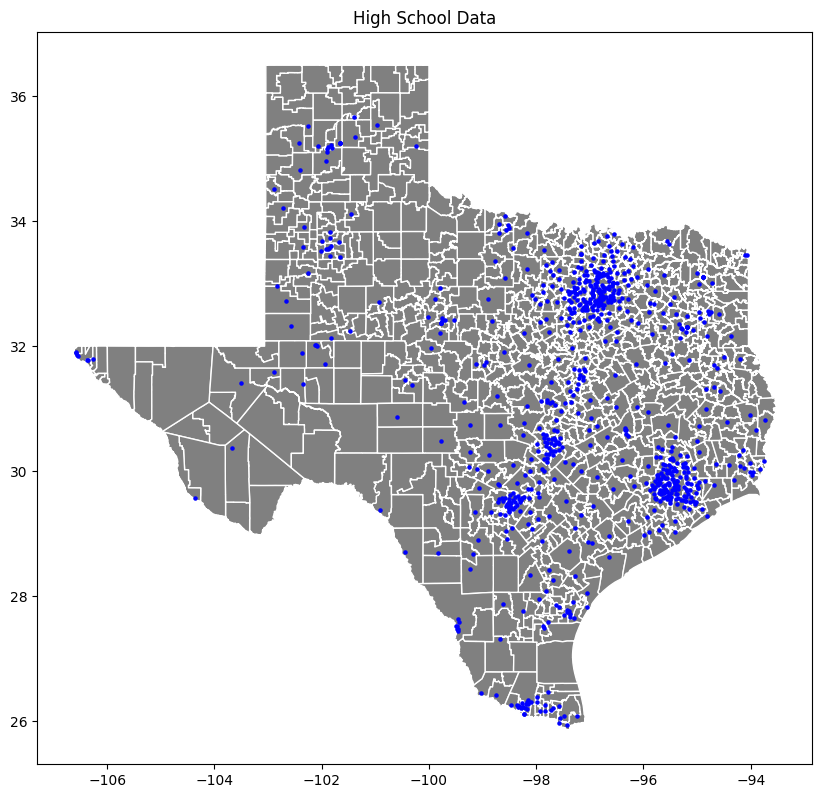

In [21]:
ax = school_districts.plot(color = 'grey', edgecolor = 'white', figsize = (10,10))
high_school.plot(ax = ax, color = 'blue', markersize = 5)
plt.title('High School Data')

In [22]:
def pull_grade_county_specific(gradespan, county_name):
    joined = gpd.sjoin(gradespan, counties, how = "inner", predicate = "within")
    county_spec = joined[joined['County'] == county_name]
    output1 = gpd.GeoDataFrame(county_spec)
    return output1

In [23]:
# county specific data for Harris County
harris = counties[counties['County'] == 'HARRIS']

# county middle schools
harris_ms = pull_grade_county_specific(middle_school, "HARRIS")
harris_ms = harris_ms.drop('index_right', axis = 1)

# county high schools
harris_hs = pull_grade_county_specific(high_school, "HARRIS")
harris_hs = harris_hs.drop('index_right', axis = 1)

In [24]:
harris_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/raw_HARRIS_MS.shp')

In [25]:
harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/raw_HARRIS_HS.shp')

# Functions

In [26]:
# plot raw data
def plot_raw_data(geo_scale, gradespan, var, fig_name, cmap_code):
  ax = geo_scale.plot(color = 'grey', edgecolor = 'white', figsize = (10,10))
  gradespan.plot(column = var, cmap = cmap_code, ax = ax, markersize = 5, legend = True, scheme = 'quantiles')
  plt.title(fig_name)

In [27]:
def spatial_join_counties(gradespan, var, fig_name, cmap_code):
  sj_county = gpd.sjoin(gradespan, counties, how = "inner", predicate = "within")

  by_county = sj_county.groupby(
      ['County'],
      as_index=False,
  )[var].mean()

  counties_var = counties.merge(by_county, how = 'inner', on = 'County')
  return counties_var

In [28]:
def spatial_join_district(geo_scale, gradespan, var, fig_name, cmap_code):
  sj_district = gpd.sjoin(gradespan, school_districts, how = "inner", predicate = "within")

  # average tsr in each county
  by_district = sj_district.groupby(
      ['NAME'],
      as_index=False,
  )[var].mean()

  district_vars = school_districts.merge(by_district, how = 'inner', on = 'NAME')
  return district_vars

# Middle School Analysis

## Teacher to Student Ratio

In [29]:
!pip install pysal --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 83.0 MB/s eta 0:00:00
  Preparing metadata (setup.

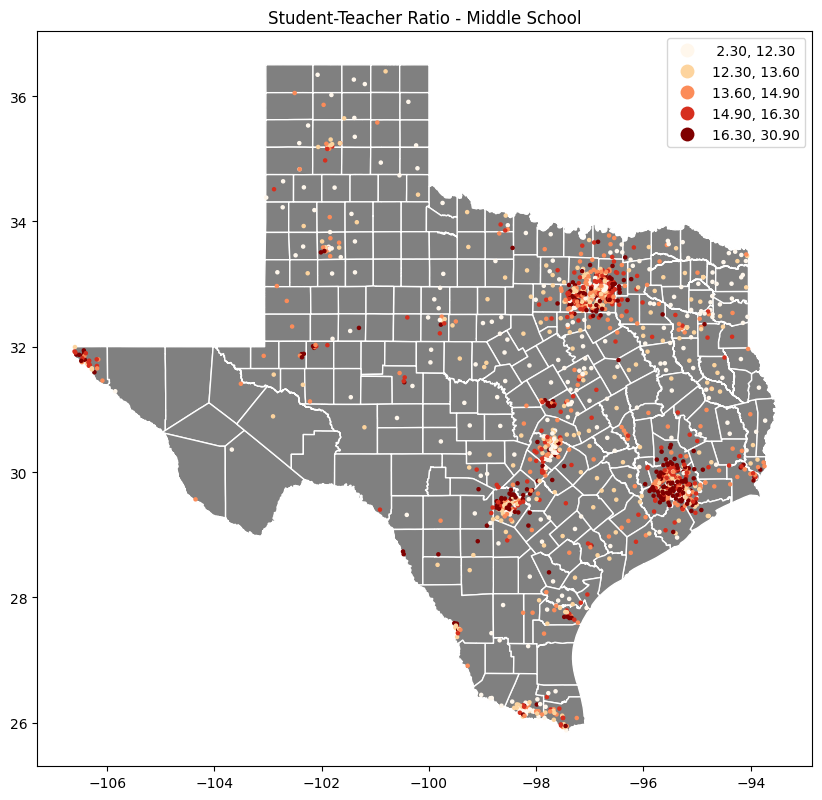

In [30]:
plot_raw_data(counties, middle_school, 'Teacher_Student_Ratio', 'Student-Teacher Ratio - Middle School', 'OrRd')

In [31]:
# plot the teacher to student ratio for counties
sj_tsr_ms = spatial_join_counties(middle_school, 'Teacher_Student_Ratio', 'Teacher to Student Ratio by County - Middle School', 'OrRd')
sj_tsr_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/TSR_MS.shp')

In [32]:
# Perform spatial join and save the result to a shapefile.
sj_tsr_district_harris_ms = spatial_join_district(harris, harris_ms, 'Teacher_Student_Ratio', 'Teacher to Student Ratio by District - Middle School', 'RdYlBu')
sj_tsr_district_harris_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_TSR_Harris_by_District.shp')

## Chronic_Absenteeism_Rate

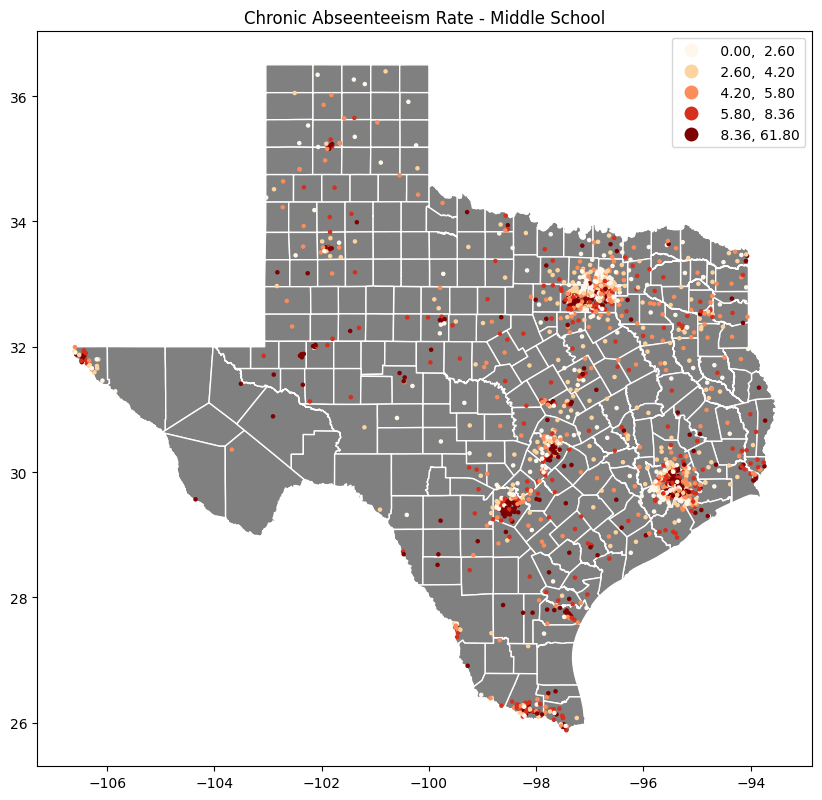

In [33]:
# Plot raw data using specified parameters
plot_raw_data(counties, middle_school, 'Chronic_Absenteeism_Rate', 'Chronic Abseenteeism Rate - Middle School', 'OrRd')

In [34]:
# Perform spatial join for Chronic Absenteeism Rate by County for Middle Schools and save the result to a shapefile.
sj_car_ms = spatial_join_counties(middle_school, 'Chronic_Absenteeism_Rate', 'Chronic Abseenteeism Rate by County - Middle Schools', 'OrRd')
sj_car_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/CAR_MS.shp')

In [35]:
# Perform spatial join for Chronic Absenteeism Rate by District for Middle Schools in Harris County and save the result to a shapefile.
sj_car_district_harris_ms = spatial_join_district(harris, harris_ms, 'Chronic_Absenteeism_Rate', 'Chronic Abseenteeism Rate by District - Middle School', 'RdYlBu')
sj_car_district_harris_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_CAR_Harris_by_District.shp')

## Dropout Rate

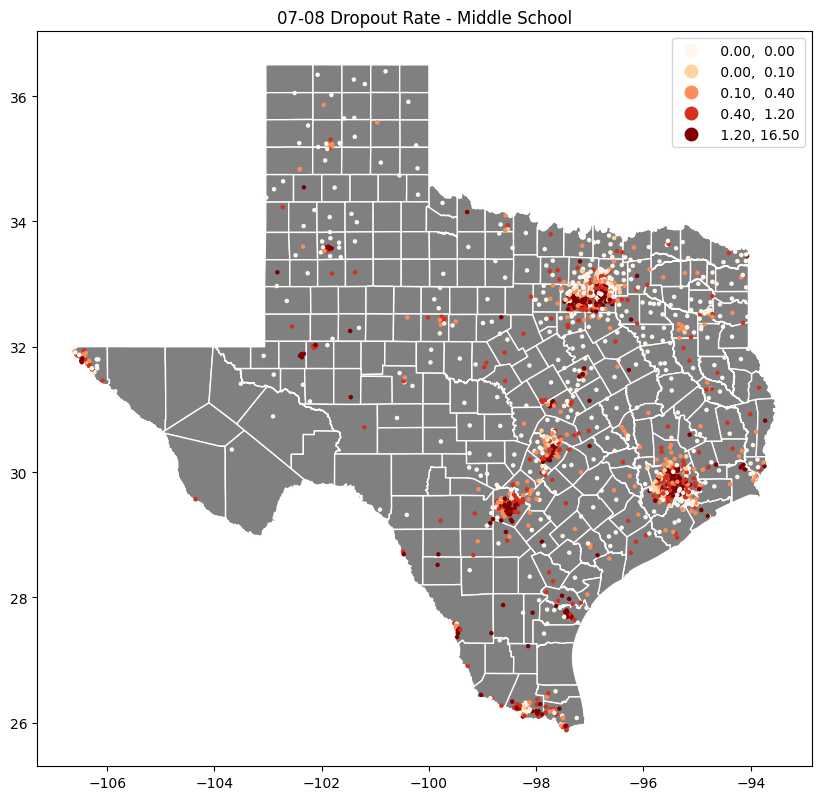

In [36]:
# Plot raw data for the 07-08 Dropout Rate in Middle Schools
plot_raw_data(counties, middle_school, 'Dropout_0708', '07-08 Dropout Rate - Middle School', 'OrRd')

In [37]:
# Perform spatial join for the 07-08 Dropout Rate by County for Middle Schools and save the result to a shapefile.
sj_dr0708_ms = spatial_join_counties(middle_school, 'Dropout_0708', '07-08 Dropout Rate by County - Middle Schools', 'OrRd')
sj_dr0708_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/DR0708_MS.shp')

In [38]:
# Perform spatial join for the 07-08 Dropout Rate by District for Middle Schools in Harris County and save the result to a shapefile.
sj_dr0708_district_harris_ms = spatial_join_district(harris, harris_ms, 'Dropout_0708', '07-08 Dropout Rate by District - Middle School', 'RdYlBu')
sj_dr0708_district_harris_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_DR0708_Harris_by_District.shp')

## Meet Grade Level Standard

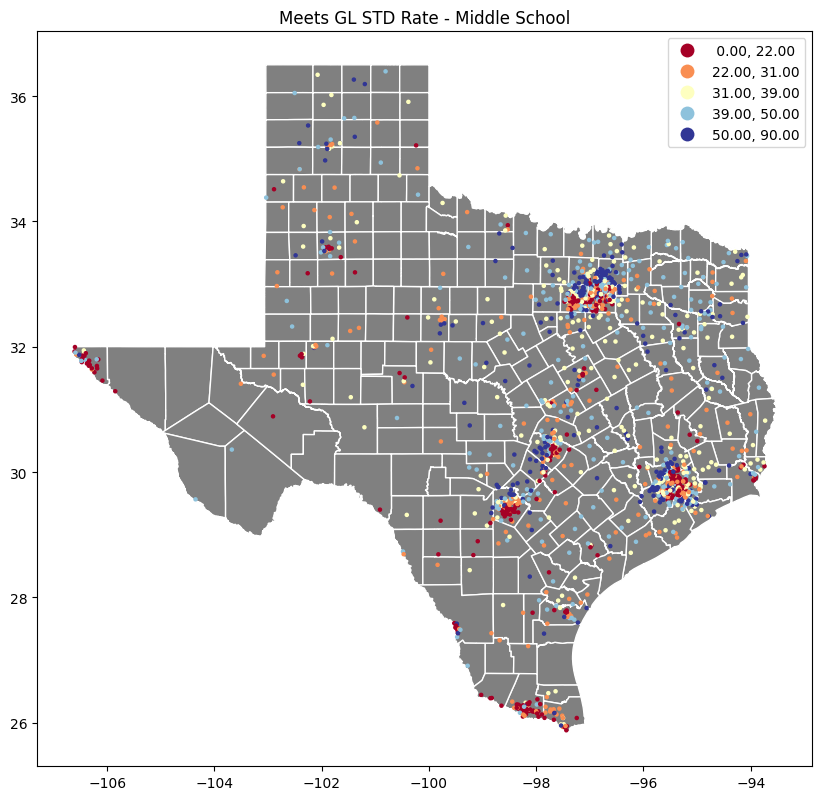

In [39]:
plot_raw_data(counties, middle_school, 'Meets_GL_STD', 'Meets GL STD Rate - Middle School', 'RdYlBu')

In [40]:
sj_mgl_ms = spatial_join_counties(middle_school, 'Meets_GL_STD', 'Meets GL STD Rate by County - Middle Schools', 'RdYlBu')
sj_mgl_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MGL_MS.shp')

In [41]:
sj_mgl_district_harris_ms = spatial_join_district(harris, harris_ms, 'Meets_GL_STD', 'Meets GL STD Rate by District - Middle School', 'RdYlBu')
sj_mgl_district_harris_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_MGL_Harris_by_District.shp')

# High School Analysis

## Teacher to Student Ratio

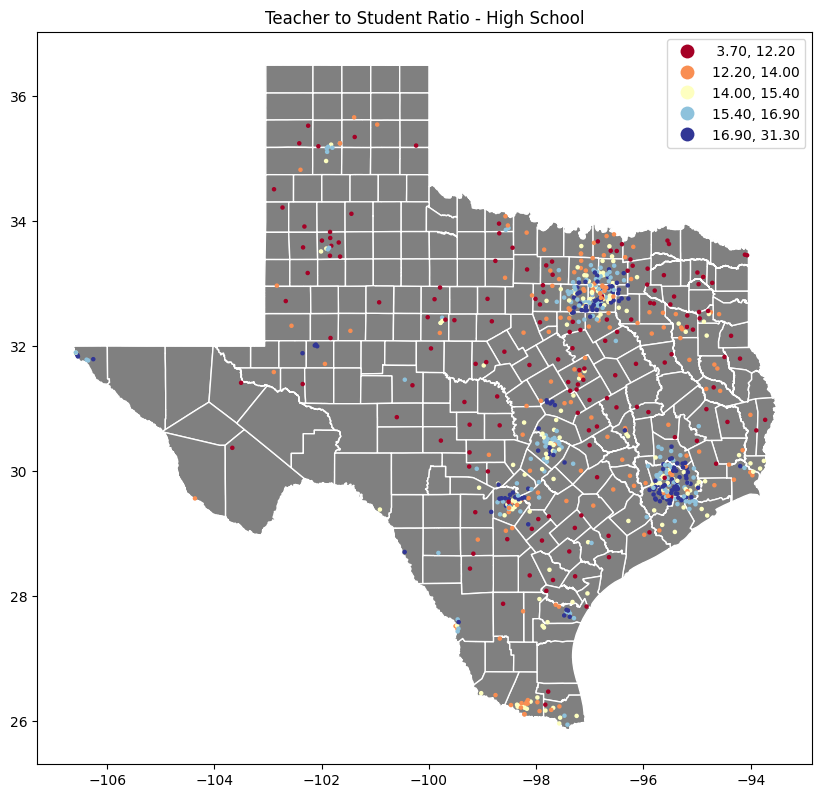

In [42]:
plot_raw_data(counties, high_school, 'Teacher_Student_Ratio', 'Teacher to Student Ratio - High School', 'RdYlBu')

In [43]:
sj_tsr_hs = spatial_join_counties(high_school, 'Teacher_Student_Ratio', 'Teacher to Student Ratio by County - High School', 'RdYlBu')
sj_tsr_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/TSR_HS.shp')

In [44]:
sj_tsr_district_harris_hs = spatial_join_district(harris, harris_hs, 'Teacher_Student_Ratio', 'Teacher to Student Ratio by District - High School', 'RdYlBu')
sj_tsr_district_harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_TSR_Harris_by_District.shp')

## Chronic_Absenteeism_Rate

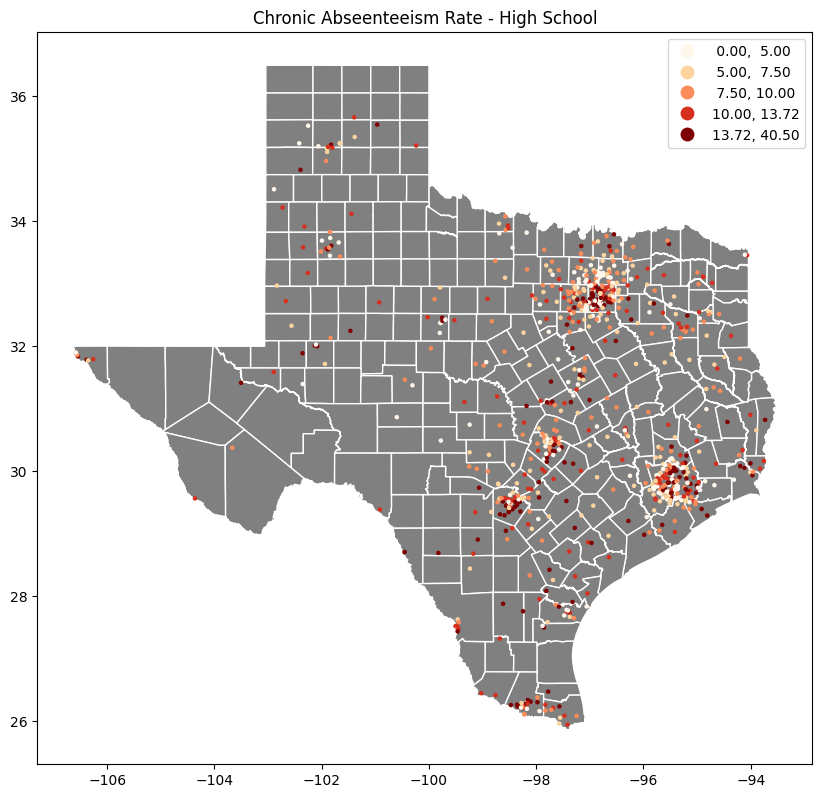

In [45]:
plot_raw_data(counties, high_school, 'Chronic_Absenteeism_Rate', 'Chronic Abseenteeism Rate - High School', 'OrRd')

In [46]:
sj_car_hs = spatial_join_counties(high_school, 'Chronic_Absenteeism_Rate', 'Chronic Abseenteeism Rate by County - High Schools', 'OrRd')
sj_car_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/CAR_HS.shp')

In [47]:
sj_car_district_harris_hs = spatial_join_district(harris, harris_hs, 'Chronic_Absenteeism_Rate', 'Chronic Abseenteeism Rate by District - High School', 'RdYlBu')
sj_car_district_harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_CAR_Harris_by_District.shp')

## Dropout Rate

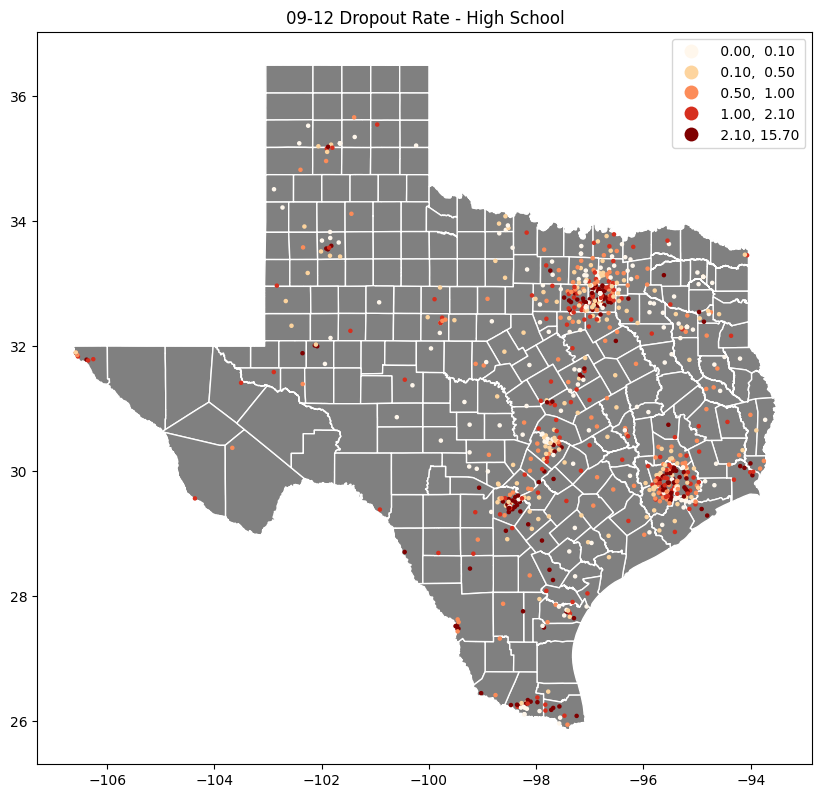

In [48]:
plot_raw_data(counties, high_school, 'Dropout_0912', '09-12 Dropout Rate - High School', 'OrRd')

In [49]:
sj_dr0912_hs = spatial_join_counties(high_school, 'Dropout_0912', '09-12 Dropout Rate by County - High Schools', 'OrRd')
sj_dr0912_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/DR0912_HS.shp')

In [50]:
sj_dr0912_district_harris_hs = spatial_join_district(harris, harris_hs, 'Dropout_0912', '09-12 Dropout Rate by District - High School', 'RdYlBu')
sj_dr0912_district_harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_DR0912_Harris_by_District.shp')

## Meet Grade Level Standard

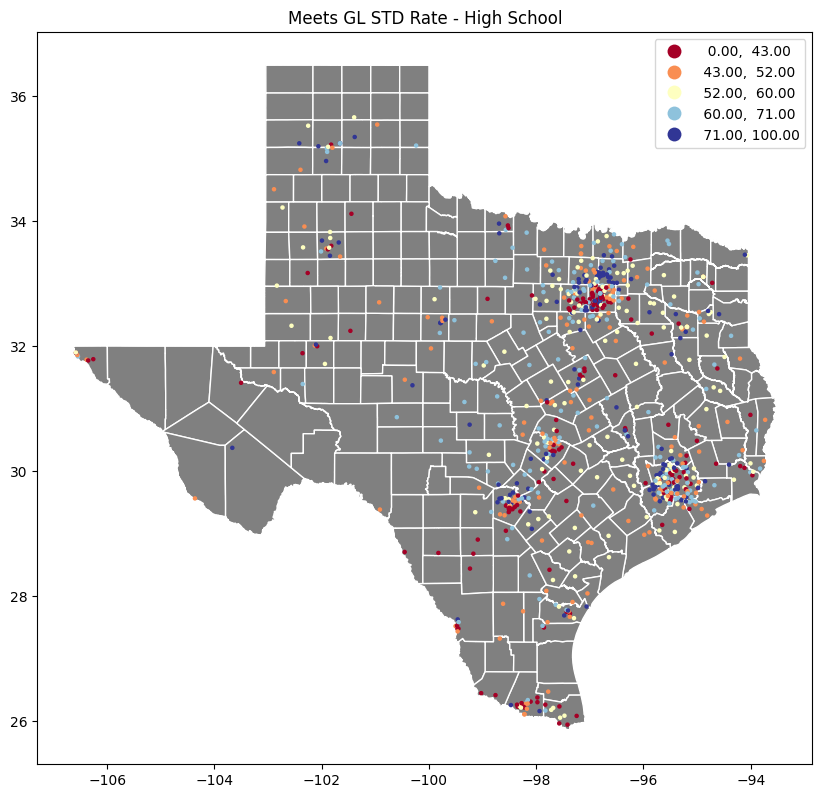

In [51]:
plot_raw_data(counties, high_school, 'Meets_GL_STD', 'Meets GL STD Rate - High School', 'RdYlBu')

In [52]:
sj_mgl_hs = spatial_join_counties(high_school, 'Meets_GL_STD', 'Meets GL STD Rate by County - High Schools', 'RdYlBu')
sj_mgl_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MGL_HS.shp')

In [53]:
sj_mgl_district_harris_hs = spatial_join_district(harris, harris_hs, 'Meets_GL_STD', 'Meets GL STD Rate by District - High School', 'RdYlBu')
sj_mgl_district_harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_MGL_Harris_by_District.shp')

## SAT Average

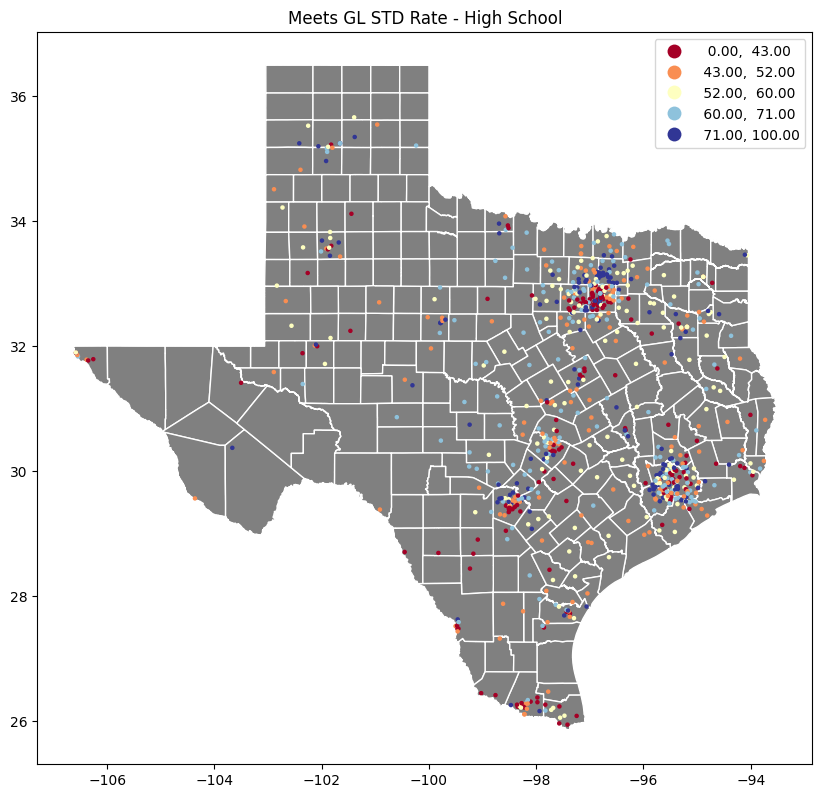

In [54]:
plot_raw_data(counties, high_school, 'Meets_GL_STD', 'Meets GL STD Rate - High School', 'RdYlBu')

In [55]:
sj_sat_hs = spatial_join_counties(high_school, 'SAT_Avg', 'SAT Average by County - High Schools', 'RdYlBu')
sj_sat_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/SAT_HS.shp')

In [56]:
sj_sat_district_harris_hs = spatial_join_district(harris, harris_hs, 'SAT_Avg', 'SAT Average by District - High School', 'RdYlBu')
sj_sat_district_harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_SAT_Harris_by_District.shp')

## ACT Average

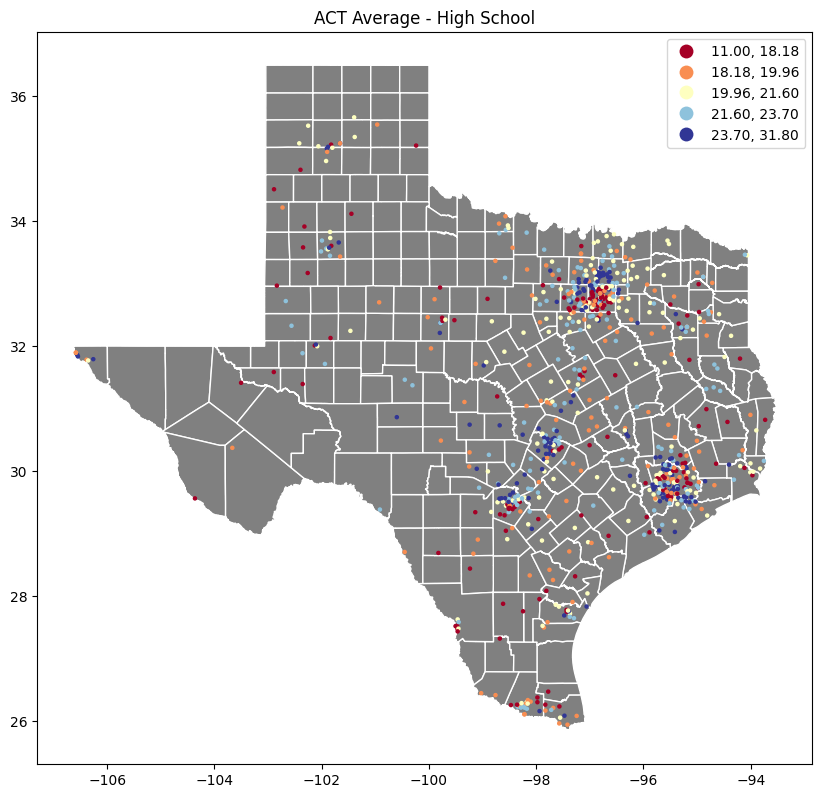

In [57]:
plot_raw_data(counties, high_school, 'ACT_Avg', 'ACT Average - High School', 'RdYlBu')

In [58]:
sj_act_hs = spatial_join_counties(high_school, 'ACT_Avg', 'ACT Average by County - High Schools', 'RdYlBu')
sj_act_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/ACT_HS.shp')

In [59]:
sj_act_district_harris_hs = spatial_join_district(harris, harris_hs, 'ACT_Avg', 'ACT Average by District - High School', 'RdYlBu')
sj_act_district_harris_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_ACT_Harris_by_District.shp')

# K-Means Analysis

In [60]:
# define variables for clustering
all_var_hs = ['Chronic_Absenteeism_Rate', 'Dropout_0912', 'Teacher_Student_Ratio', 'SAT_Avg', 'ACT_Avg', 'Meets_GL_STD']
all_var_ms = ['Chronic_Absenteeism_Rate', 'Dropout_0708', 'Teacher_Student_Ratio', 'Meets_GL_STD']

## Data

In [61]:
sj_county_ms = gpd.sjoin(middle_school, counties, how = "inner", predicate = "within")

ms_by_county = sj_county_ms.groupby(
      ['County'],
      as_index=False,
  )[all_var_ms].mean()

counties_all_ms = counties.merge(ms_by_county, how = 'inner', on = 'County')
counties_all_ms.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/All_Var_MS_by_County.shp')

In [62]:
sj_county_hs = gpd.sjoin(high_school, counties, how = "inner", predicate = "within")

hs_by_county = sj_county_hs.groupby(
      ['County'],
      as_index=False,
  )[all_var_hs].mean()

counties_all_hs = counties.merge(hs_by_county, how = 'inner', on = 'County')

counties_all_hs.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/All_Var_HS_by_County.shp')

In [63]:
sj_hs_district = gpd.sjoin(high_school, school_districts, how = "inner", predicate = "within")

# average tsr in each county
hs_by_district = sj_hs_district.groupby(
    ['NAME'],
    as_index=False,
)[all_var_hs].mean()

hs_by_district_all_var = school_districts.merge(hs_by_district, how = 'inner', on = 'NAME')

In [64]:
sj_harris_ms = gpd.sjoin(harris_ms, school_districts, how = "inner", predicate = "within")

# average tsr in each county
ms_by_district = sj_harris_ms.groupby(
    ['NAME'],
    as_index=False,
)[all_var_ms].mean()

harris_ms_all_var = school_districts.merge(ms_by_district, how = 'inner', on = 'NAME')

harris_ms_all_var.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/Harris_All_Var_MS_by_District.shp')

In [65]:
sj_harris_hs = gpd.sjoin(harris_hs, school_districts, how = "inner", predicate = "within")

# average tsr in each county
hs_by_district = sj_harris_hs.groupby(
    ['NAME'],
    as_index=False,
)[all_var_hs].mean()

harris_hs_all_var = school_districts.merge(hs_by_district, how = 'inner', on = 'NAME')

harris_hs_all_var.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/Harris_All_Var_HS_by_District.shp')

## Functions

In [66]:
import sklearn
from sklearn.preprocessing import MinMaxScaler #[0-1]
from sklearn.cluster import KMeans

In [67]:
# from sklearn.cluster import KMeans
# np.random.seed(1234)

In [68]:
#standardize the values by min_max
def minMaxStandardize(var):
  df_matrix= data_source
  norm = MinMaxScaler().fit(df_matrix[var])
  scaled_features = norm.transform(df_matrix[var])
  return scaled_features

# determine the optimal number of clusters.
def ElbowMethod(scaled_features):
  distortions = []
  K = range(1,10)
  for k in K:
      kmeanModel = KMeans(n_clusters=k)
      kmeanModel.fit(scaled_features)
      distortions.append(kmeanModel.inertia_)

  plt.figure(figsize=(8,4))
  plt.plot(K, distortions, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Distortion')
  plt.title('The Elbow Method showing the optimal k')
  plt.show()

# apply KMeans method to define clusters
def defClusters(scaled_features, cluster_type, num_clust):
  ms = KMeans(n_clusters=num_clust)
  cluster = ms.fit(scaled_features)
  data_source[cluster_type] = cluster.labels_

def writeMeanTable(list, cluster_name):
  mean_table = data_source.groupby(cluster_name)[list].mean()
  return mean_table

def mapKMeans(cluster_type, title):
  f, ax = plt.subplots(1, figsize=(9, 9))
  data_source.plot(column=cluster_type, categorical=True, legend=True, linewidth=0, ax=ax)
  ax.set_axis_off()
  plt.title(title)
  plt.show()

def kmeansPlot(list, cluster_type):
  tidy_db = data_source.set_index(cluster_type)
  tidy_db = tidy_db[list]
  tidy_db = tidy_db.stack()
  tidy_db = tidy_db.reset_index()
  tidy_db = tidy_db.rename(columns={'level_1': 'Attribute', 0: 'Values'})
  tidy_db.head()

  seaborn.set(font_scale = 1.5)
  facets = seaborn.FacetGrid(
      data=tidy_db,
      col='Attribute',
      hue=cluster_type,
      sharey=False,
      sharex=False,
      aspect=2,
      col_wrap=3
  )
  # Build the plot from `sns.kdeplot`
  _ = facets.map(seaborn.kdeplot, 'Values', fill=True).add_legend()

def outputKVals(list, num_clusters, cluster_type):
  for i in range(len(list)):
    fvalue, pvalue = plt_dist(data_source, cluster_type, list[i], num_clusters)
    print (list[i], fvalue,pvalue)

def pairPlot(list):
  _ = seaborn.pairplot(data_source[list], kind='reg', diag_kind='kde')

#ANOVA statistical analysis
def plt_dist(all_type_data, cluster, var, num_clusters):
    is_wkn1 = all_type_data[cluster] == 0
    is_wkn2 = all_type_data[cluster] == 1
    cl1= all_type_data[is_wkn1]
    cl2= all_type_data[is_wkn2]
    cl1_a = np.array(cl1[var]).astype(float)
    cl2_a = np.array(cl2[var]).astype(float)

    if num_clusters >= 3:
      is_wkn3 = all_type_data[cluster] == 2
      cl3= all_type_data[is_wkn3]
      cl3_a = np.array(cl3[var]).astype(float)
    if num_clusters >= 4:
      is_wkn4 = all_type_data[cluster] == 3
      cl4= all_type_data[is_wkn4]
      cl4_a = np.array(cl4[var]).astype(float)

    if num_clusters == 2:
      fvalue, pvalue = stats.f_oneway(cl1_a, cl2_a)

    if num_clusters == 3:
      fvalue, pvalue = stats.f_oneway(cl1_a, cl2_a, cl3_a)
    if num_clusters == 4:
      fvalue, pvalue = stats.f_oneway(cl1_a, cl2_a, cl3_a, cl4_a)

    return fvalue, pvalue

## Application of K-Means Clustering

### Middle School

In [69]:
data_source = counties_all_ms

In [70]:
scaled_ms = minMaxStandardize(all_var_ms)

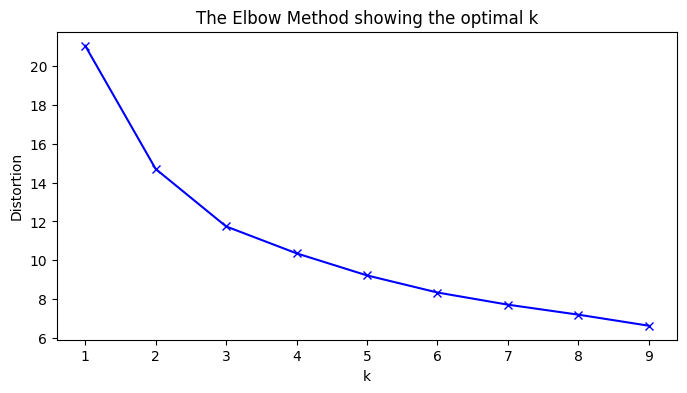

In [71]:
# apply the elbow method to determine the optimal clusters
ElbowMethod(scaled_ms)

In [72]:
# set cluster number based on elbow
num_clust_ms  = 3

In [73]:
# define clusters using K Means
defClusters(scaled_ms, 'ms_cluster', num_clust_ms)

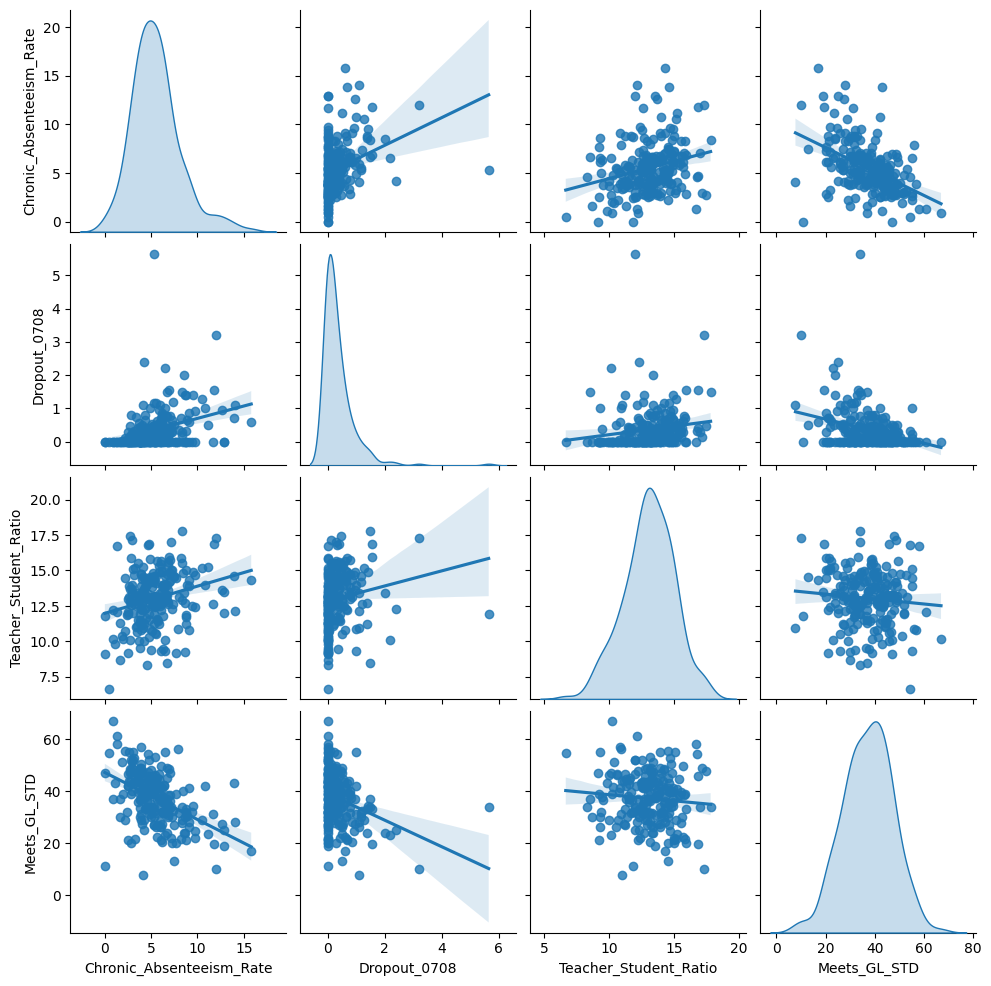

In [74]:
# develop matrix to show data relationship
pairPlot(all_var_ms)

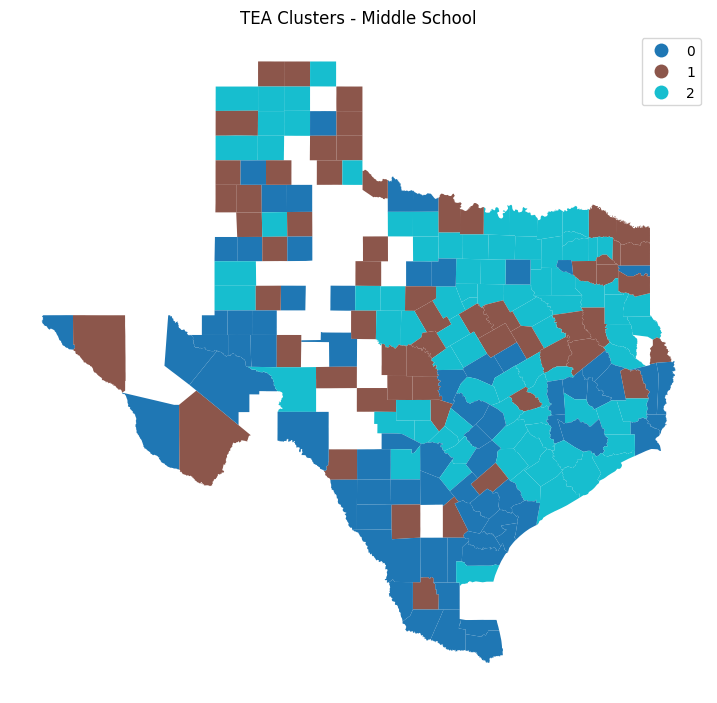

In [75]:
# map ms clusters
mapKMeans('ms_cluster', 'TEA Clusters - Middle School')

In [76]:
#  examine the differences in mean values across each cluster
writeMeanTable(all_var_ms, 'ms_cluster')

Chronic_Absenteeism_Rate  Dropout_0708  Teacher_Student_Ratio  \
ms_cluster                                                                  
0                           7.929630      0.716001              13.913062   
1                           4.139349      0.140837              10.737909   
2                           4.432402      0.226877              13.871046   

            Meets_GL_STD  
ms_cluster                
0              27.888754  
1              38.513559  
2              43.982735

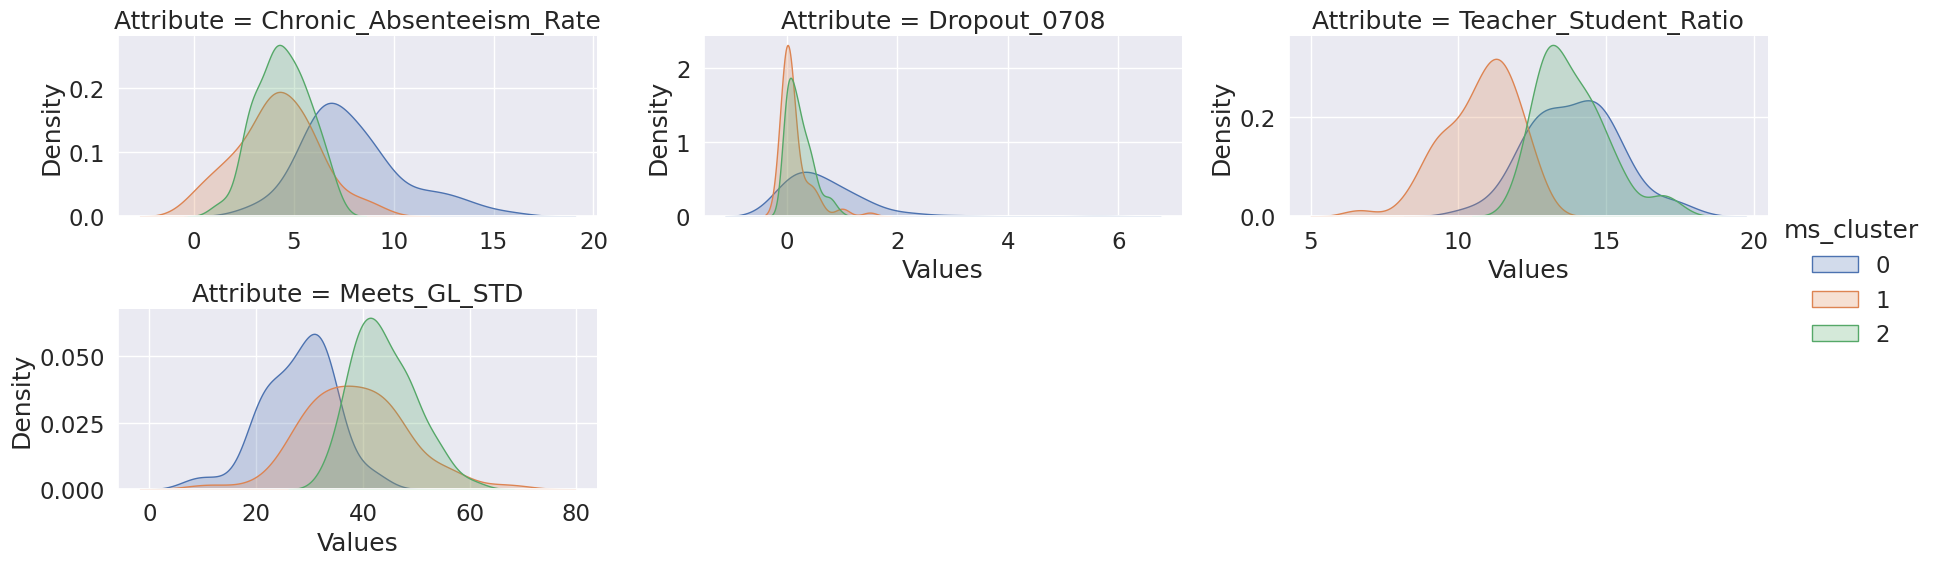

In [77]:
# plot values by cluster
kmeansPlot(all_var_ms, 'ms_cluster')

In [78]:
# output clusters for middle school
data_source.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_Clusters.shp')

In [79]:
# output fvalue and pvalue for each var
outputKVals(all_var_ms, num_clust_ms, 'ms_cluster')

Chronic_Absenteeism_Rate 79.14705867272995 1.8597438718235145e-26
Dropout_0708 22.52606450958851 1.3238750534736493e-09
Teacher_Student_Ratio 121.60795131369541 5.263707155030751e-36
Meets_GL_STD 95.35311005184921 2.4564428418133826e-30


### High School

In [80]:
data_source = counties_all_hs

In [81]:
scaled_hs = minMaxStandardize(all_var_hs)

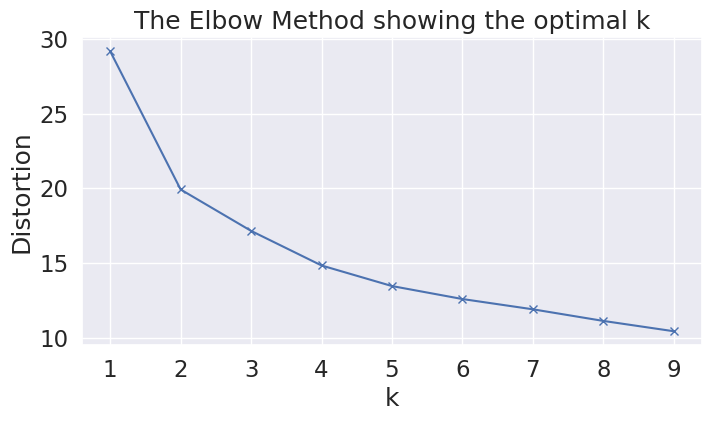

In [82]:
# apply the elbow method to determine the optimal clusters
ElbowMethod(scaled_hs)

In [83]:
# set cluster number based on elbow
num_clust_hs  = 3

In [84]:
# define clusters using K Means
defClusters(scaled_hs, 'hs_cluster', num_clust_hs)

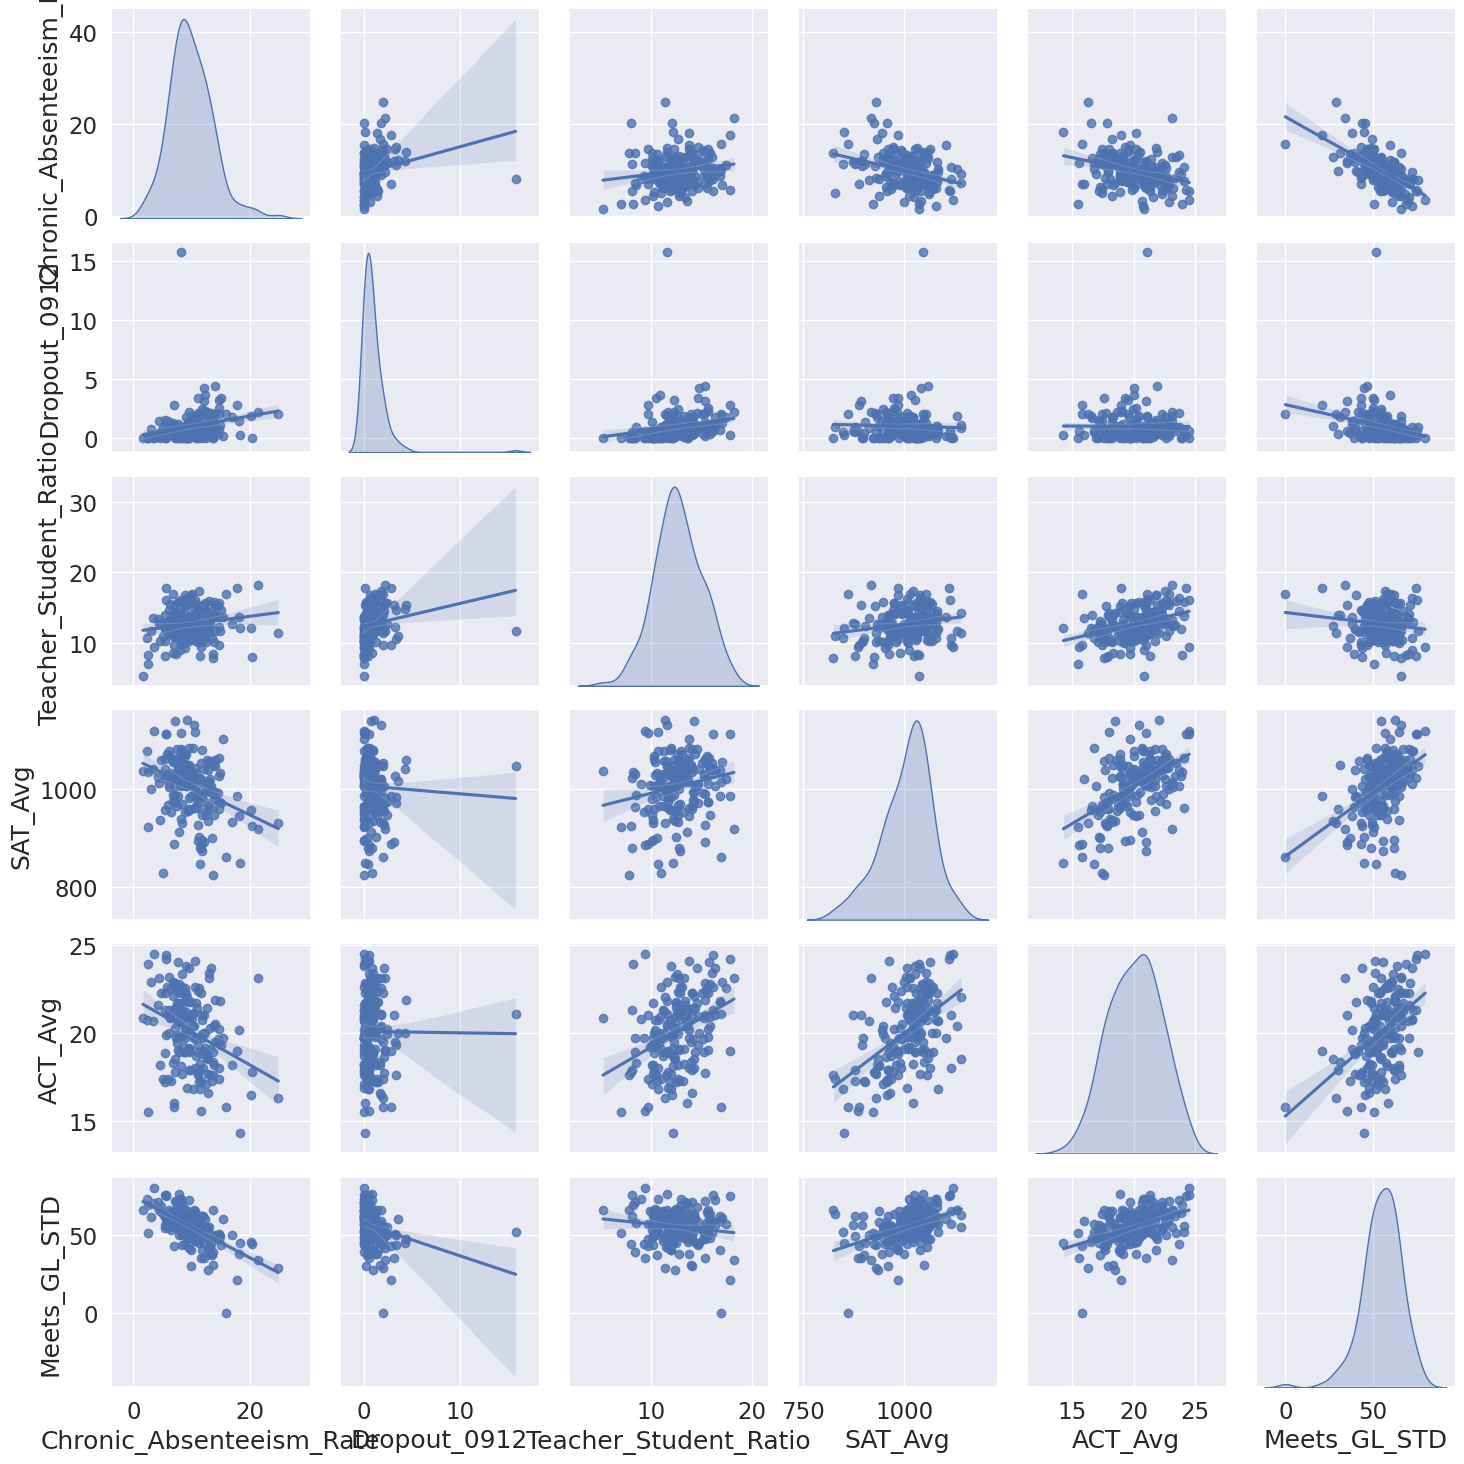

In [85]:
# develop matrix to show data relationship
pairPlot(all_var_hs)

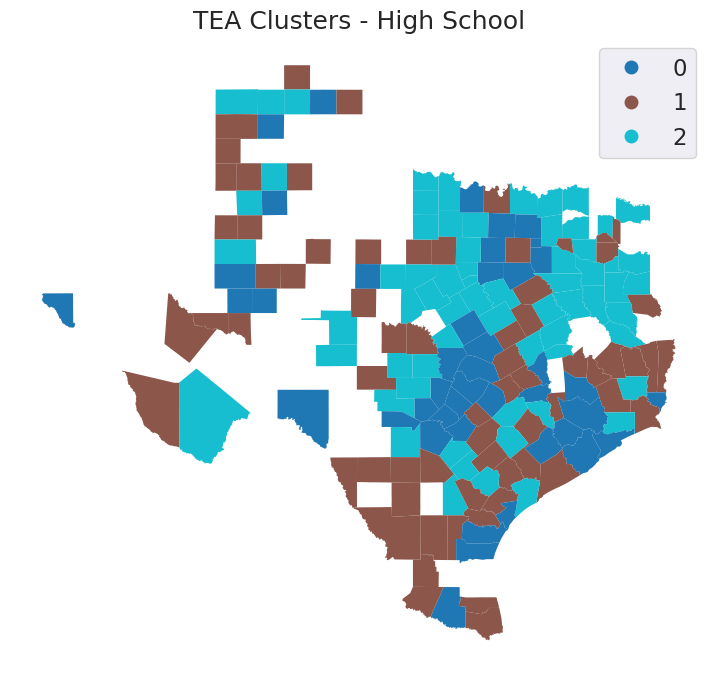

In [86]:
# map social clusters
mapKMeans('hs_cluster', 'TEA Clusters - High School')

In [87]:
#  examine the differences in mean values across each cluster
writeMeanTable(all_var_hs, 'hs_cluster')

Chronic_Absenteeism_Rate  Dropout_0912  Teacher_Student_Ratio  \
hs_cluster                                                                  
0                          10.006742      1.245621              15.331429   
1                          11.684689      1.021690              11.885612   
2                           7.879603      0.725584              11.691976   

                SAT_Avg    ACT_Avg  Meets_GL_STD  
hs_cluster                                        
0           1023.555311  21.967791     56.300603  
1            952.152262  18.147825     47.319954  
2           1046.932003  20.833363     62.050903

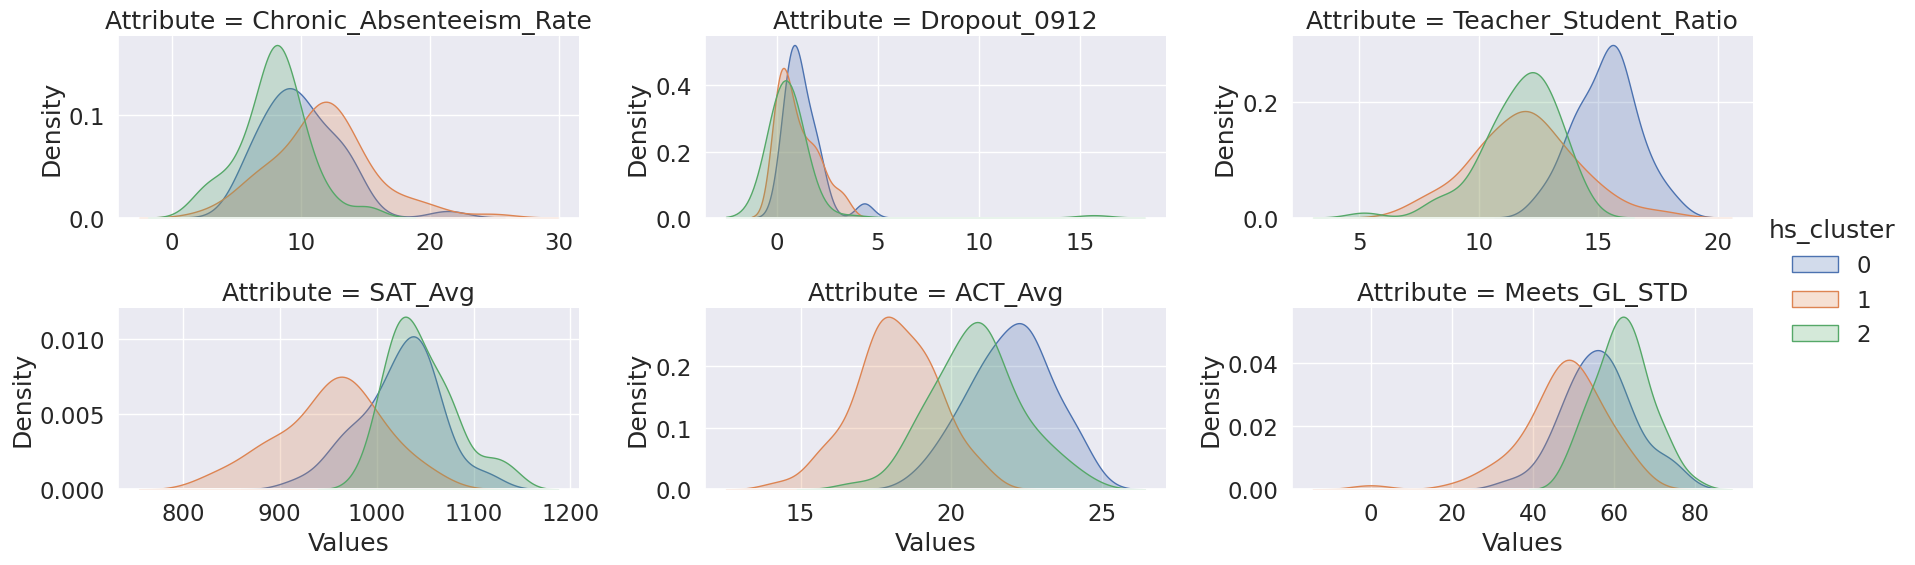

In [88]:
# plot values by cluster
kmeansPlot(all_var_hs, 'hs_cluster')

In [89]:
# output clusters for middle school
data_source.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_Clusters.shp')

In [90]:
# output fvalue and pvalue for each var
outputKVals(all_var_hs, num_clust_hs, 'hs_cluster')

Chronic_Absenteeism_Rate 22.051448330597974 2.94721598305123e-09
Dropout_0912 1.8548039765706001 0.15958195828086288
Teacher_Student_Ratio 64.00275785383238 1.564219397313629e-21
SAT_Avg 78.88115617274852 4.496268547140917e-25
ACT_Avg 111.57419671955618 7.52107044846064e-32
Meets_GL_STD 43.94991759475889 3.6813220252966716e-16


### Harris County - MS

In [91]:
data_source = harris_ms_all_var

In [92]:
scaled_ms = minMaxStandardize(all_var_ms)

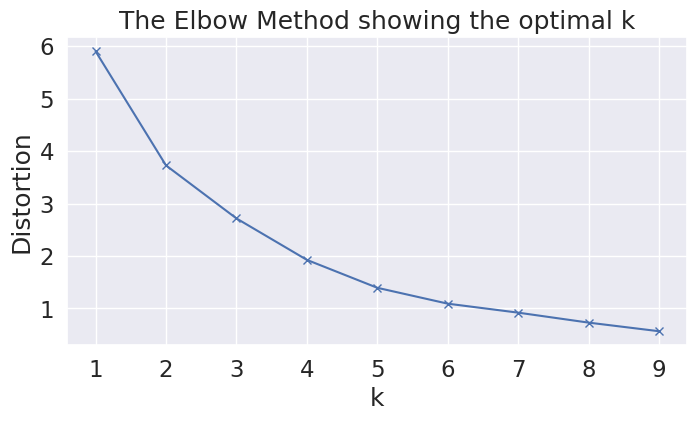

In [93]:
# apply the elbow method to determine the optimal clusters
ElbowMethod(scaled_ms)

In [94]:
# set cluster number based on elbow
num_clust_ms  = 4

In [95]:
# define clusters using K Means
defClusters(scaled_ms, 'ms_cluster_harris', num_clust_ms)

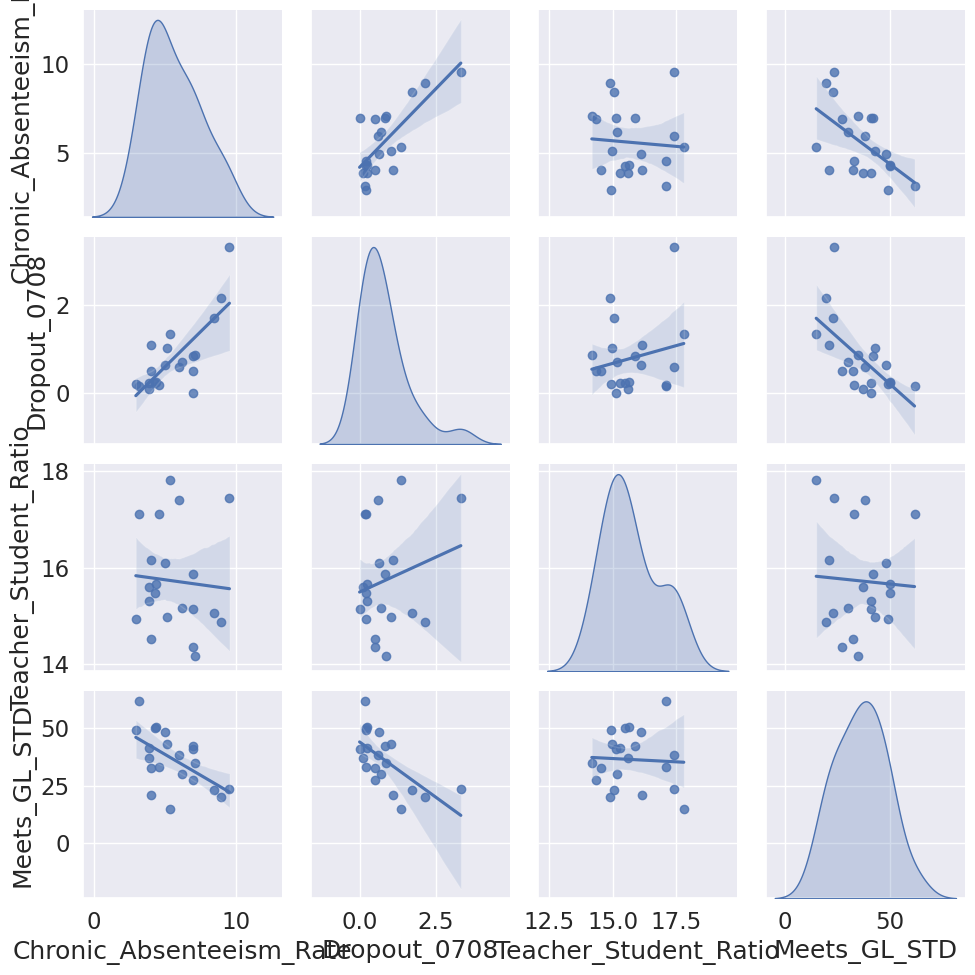

In [96]:
# develop matrix to show data relationship
pairPlot(all_var_ms)

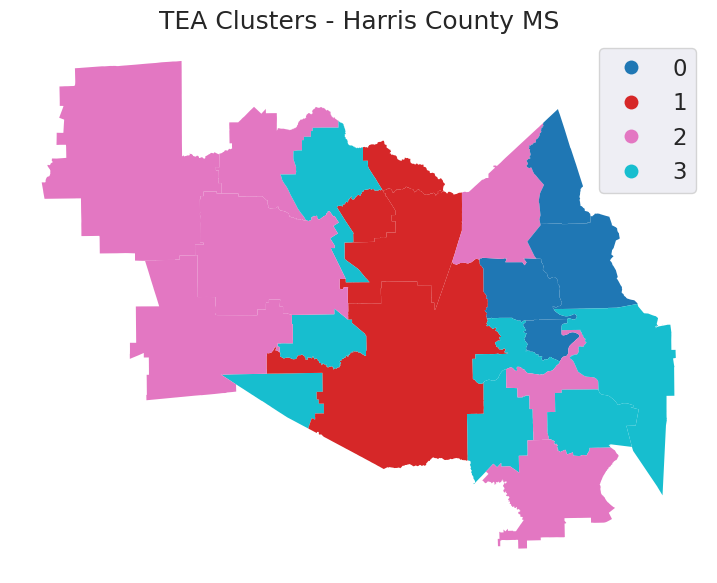

In [97]:
# map social clusters
mapKMeans('ms_cluster_harris', 'TEA Clusters - Harris County MS')

In [98]:
#  examine the differences in mean values across each cluster
writeMeanTable(all_var_ms, 'ms_cluster_harris')

Chronic_Absenteeism_Rate  Dropout_0708  \
ms_cluster_harris                                           
0                                  5.000000      0.812500   
1                                  8.973742      2.396961   
2                                  3.944275      0.261721   
3                                  6.210708      0.633956   

                   Teacher_Student_Ratio  Meets_GL_STD  
ms_cluster_harris                                       
0                              17.112500     26.750000  
1                              15.786752     22.133903  
2                              15.737338     48.213279  
3                              14.886859     35.828236

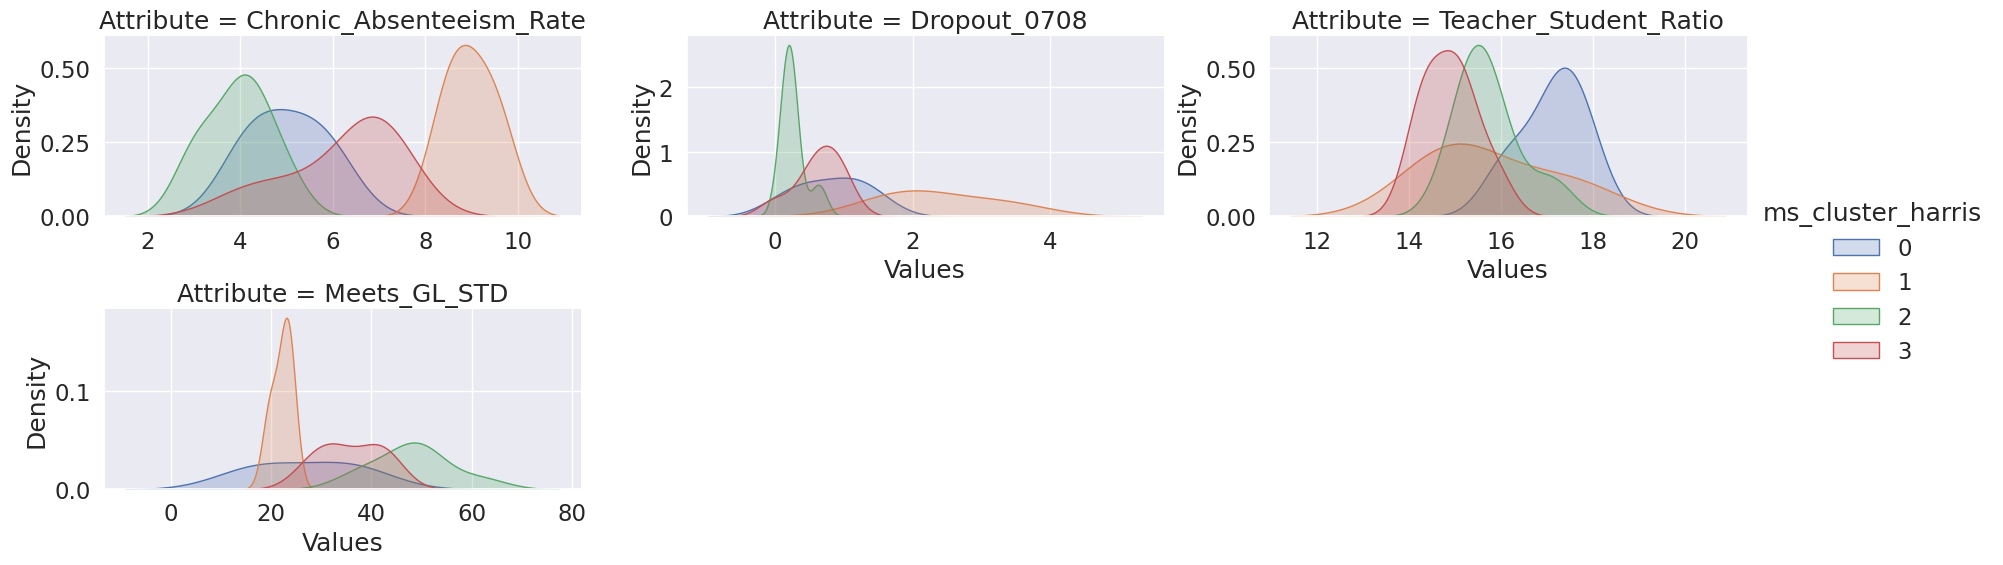

In [99]:
# plot values by cluster
kmeansPlot(all_var_ms, 'ms_cluster_harris')

In [100]:
# output clusters for middle school
data_source.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/MS_Clusters_Harris_Districts.shp')

In [101]:
# output fvalue and pvalue for each var
outputKVals(all_var_ms, num_clust_ms, 'ms_cluster_harris')

Chronic_Absenteeism_Rate 22.89106384573791 3.3324837823354052e-06
Dropout_0708 18.331444161980325 1.4315469049261661e-05
Teacher_Student_Ratio 6.832801229978533 0.0031773828888152526
Meets_GL_STD 11.849570099942103 0.0001973971491339469


### Harris County - HS

In [102]:
data_source = harris_hs_all_var

In [103]:
scaled_hs = minMaxStandardize(all_var_hs)

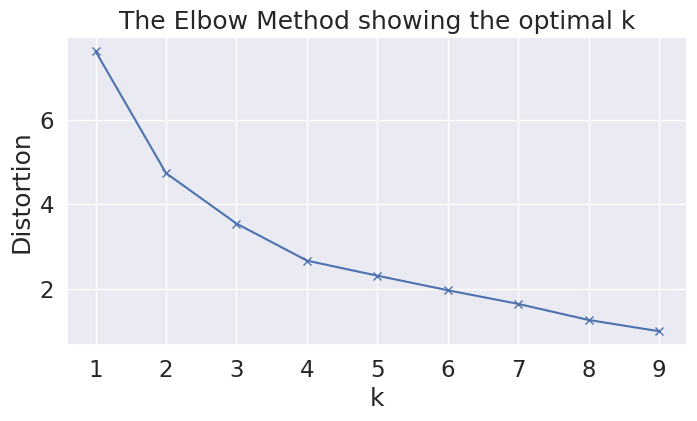

In [104]:
# apply the elbow method to determine the optimal clusters
ElbowMethod(scaled_hs)

In [105]:
# set cluster number based on elbow
num_clust_hs  = 4

In [106]:
# define clusters using K Means
defClusters(scaled_hs, 'hs_cluster_harris', num_clust_hs)

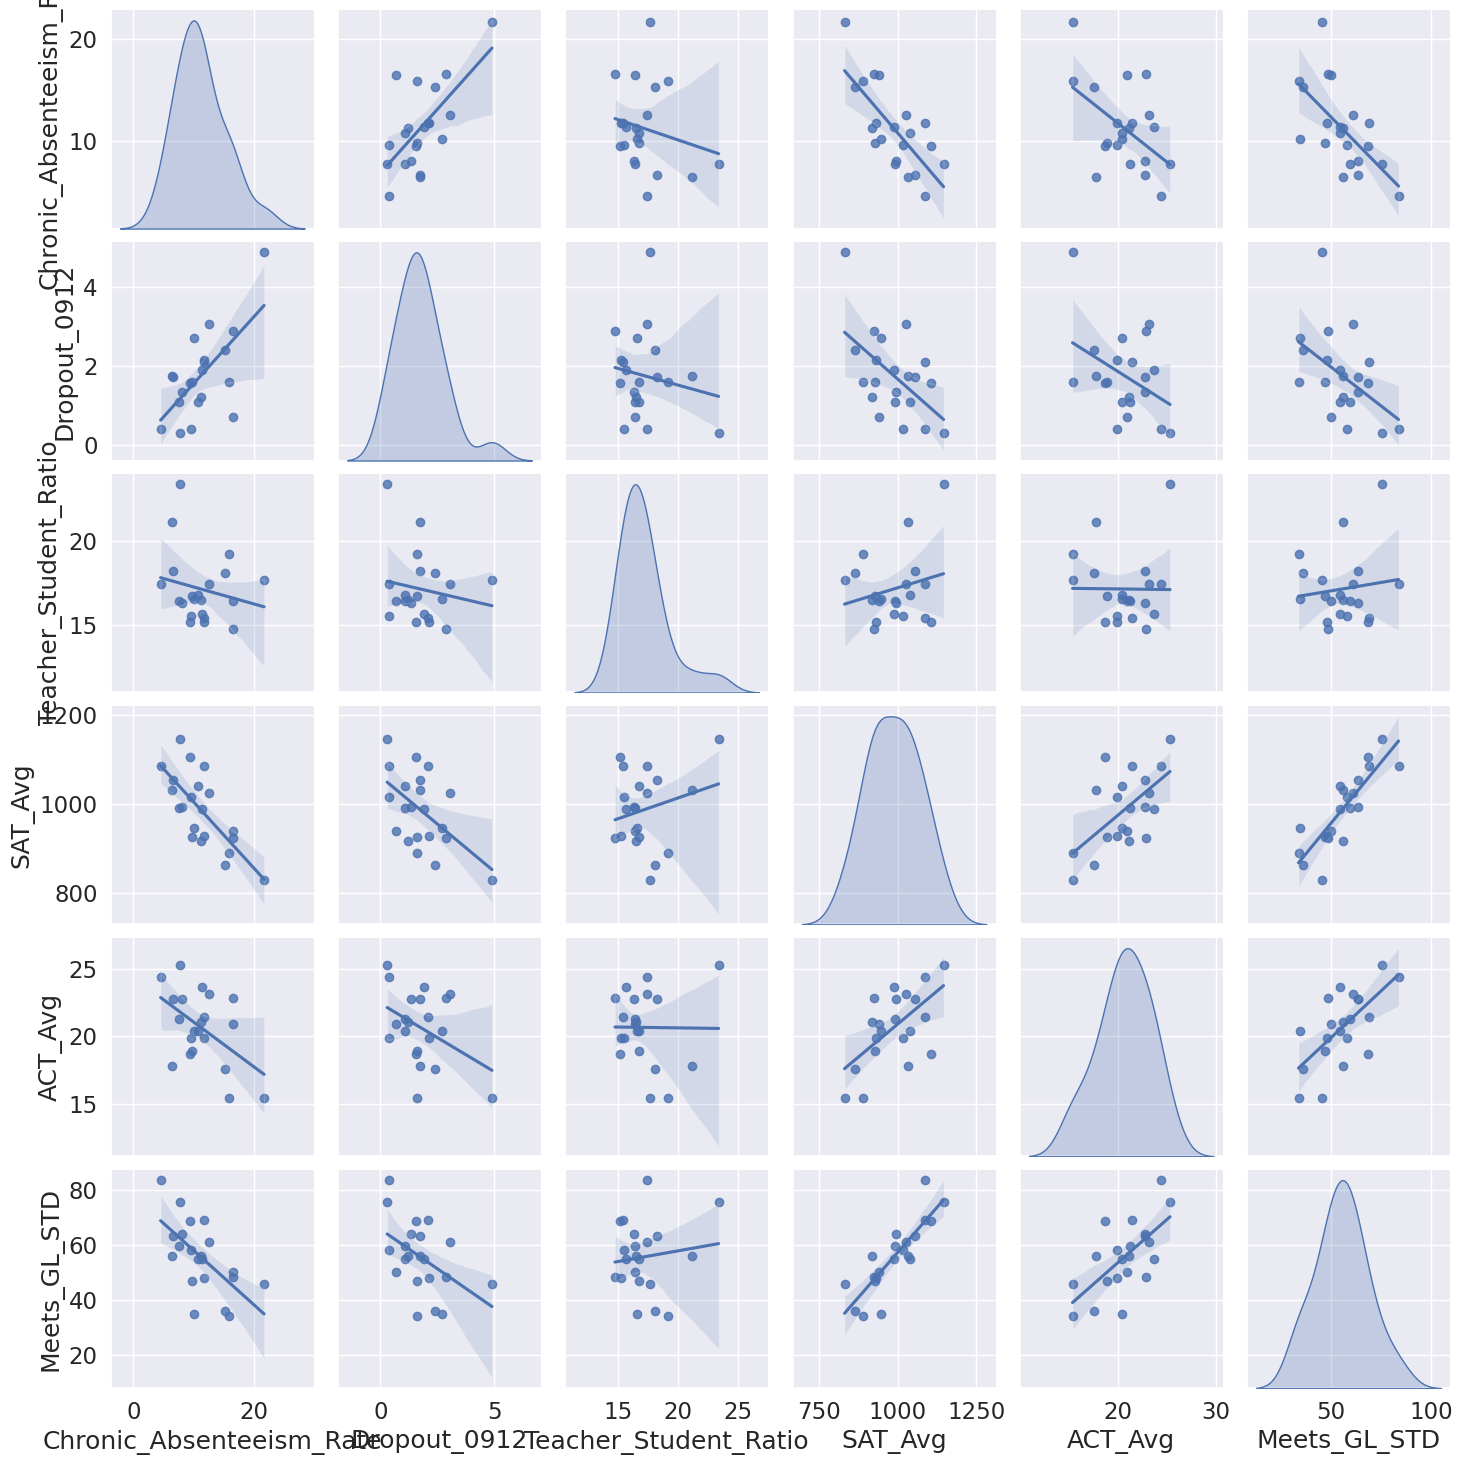

In [107]:
# develop matrix to show data relationship
pairPlot(all_var_hs)

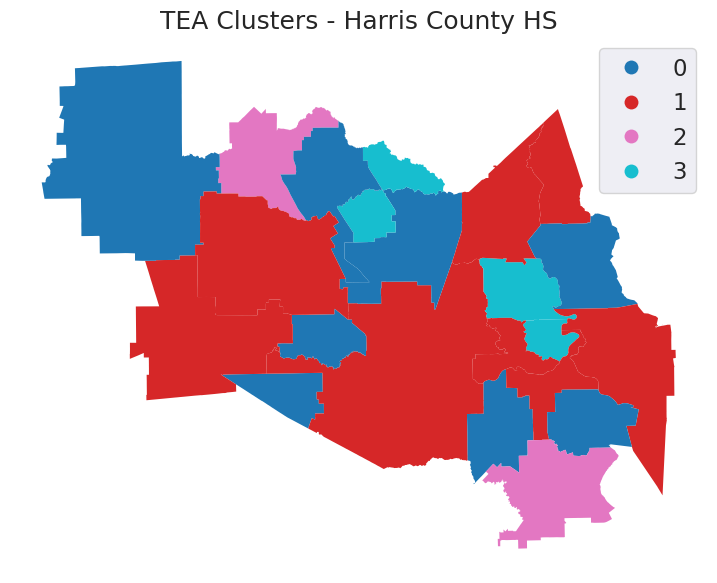

In [108]:
# map social clusters
mapKMeans('hs_cluster_harris', 'TEA Clusters - Harris County HS')

In [109]:
#  examine the differences in mean values across each cluster
writeMeanTable(all_var_hs, 'hs_cluster_harris')

Chronic_Absenteeism_Rate  Dropout_0912  \
hs_cluster_harris                                           
0                                 12.514375      2.029375   
1                                  8.784844      1.378490   
2                                  6.141667      0.350000   
3                                 17.644444      2.966667   

                   Teacher_Student_Ratio      SAT_Avg    ACT_Avg  Meets_GL_STD  
hs_cluster_harris                                                               
0                              16.146250   949.818750  21.358125     50.012500  
1                              16.861979  1039.454167  20.614792     61.614063  
2                              20.416667  1115.583333  24.850000     79.583333  
3                              18.322222   861.222222  16.155556     38.555556

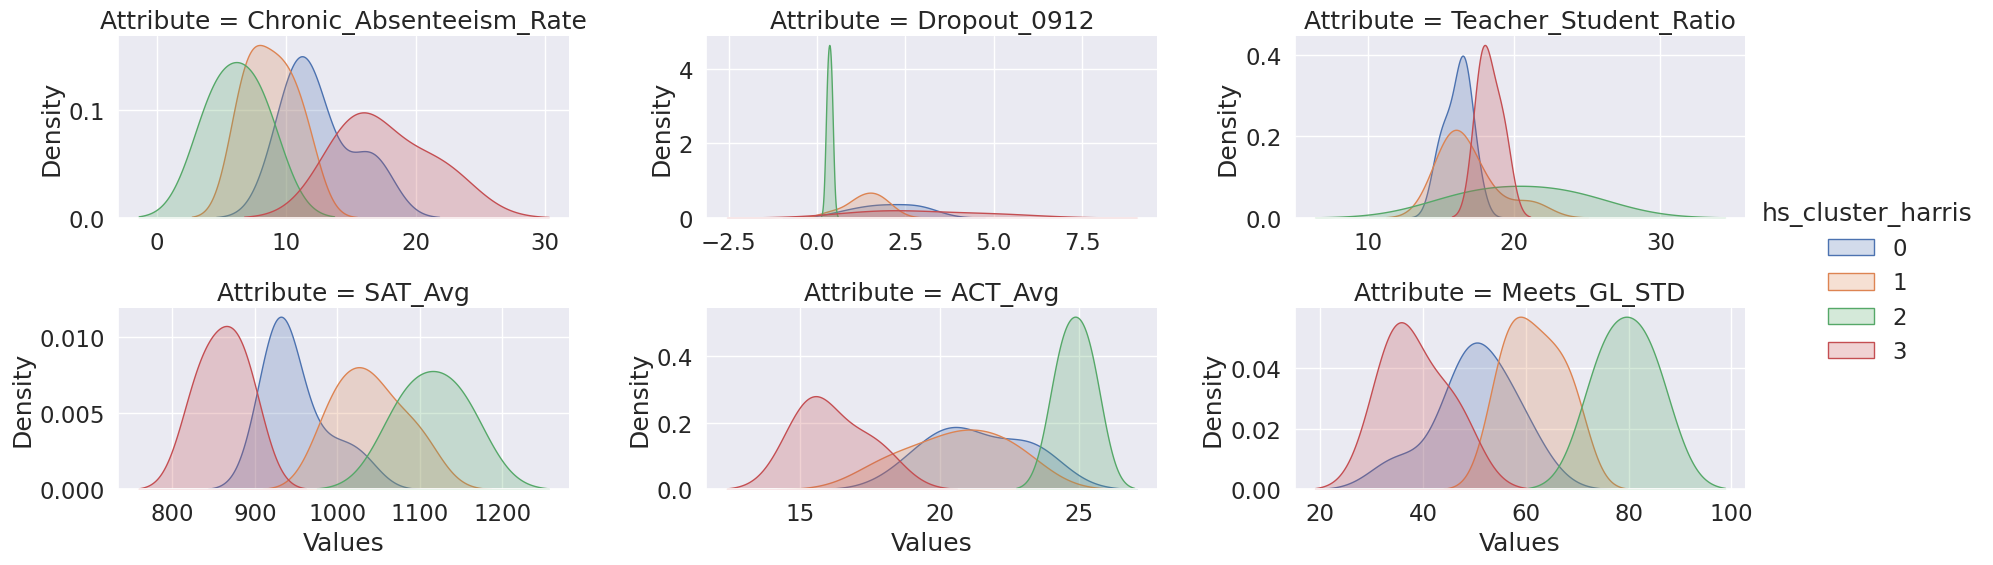

In [110]:
# plot values by cluster
kmeansPlot(all_var_hs, 'hs_cluster_harris')

In [111]:
# output clusters for middle school
data_source.to_file('/content/drive/Shareddrives/GEOG 392 676 Project/Shapefile Outputs/HS_Clusters_Harris_Districts.shp')

In [112]:
# output fvalue and pvalue for each var
outputKVals(all_var_hs, num_clust_hs, 'hs_cluster_harris')

Chronic_Absenteeism_Rate 12.79439185037959 0.00012761466471246504
Dropout_0912 4.441712120868376 0.017673236940345297
Teacher_Student_Ratio 3.7289594982341563 0.031607920249667514
SAT_Avg 25.528142036530713 1.5872737433787533e-06
ACT_Avg 12.110654352575567 0.00017459157270322765
Meets_GL_STD 19.540507053074386 9.487075850173863e-06
